# Transcript and NLP: Directly read in captions_f.json, that's all you need and selectively run cells from session 2

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import unidecode
%matplotlib inline
import copy
from nltk.corpus import stopwords
from nltk import sent_tokenize

In [2]:
import scipy.stats as ss

In [3]:
import requests
from pattern import web

## Get the transcripts 

In [4]:
# define a function to extract caption info and put into a df
def capdfget(talkid):
    capurl = 'https://api.ted.com/v1/talks/'+str(talkid)+'/captions.json?api-key=ynw2u8e4h9sk8c2htp7vutxq'
    capresponse = requests.get(capurl)
    try:
        captions = capresponse.json()['captions']
    except KeyError:
        print 'no captions, talkid: {}'.format(talkid)
        return
    captions = [x['caption'] for x in captions]
    capdf = pd.DataFrame(captions)
    capdf['id'] = talkid
    return capdf

In [5]:
cap_talk1 = capdfget(1)

In [8]:
cap_talk1.columns = ['Subtitle','Duration (ms)','Start of Paragraph', 'Start Time (ms)','id']

In [12]:
cap_talk1.drop('id',axis = 1).head(11)

,Subtitle,Duration (ms),Start of Paragraph,Start Time (ms)
0,"Thank you so much, Chris. And it's truly a gre...",4000,True,3000
1,to have the opportunity to come to this stage ...,4000,False,7000
2,"I have been blown away by this conference, and...",7000,False,11000
3,nice comments about what I had to say the othe...,5000,False,18000
4,"And I say that sincerely, partly because -- (M...",12000,False,23000
5,Put yourselves in my position!,8000,False,35000
6,I flew on Air Force Two for eight years.,5000,False,43000
7,Now I have to take off my shoes or boots to ge...,3000,False,48000
8,(Laughter) (Applause),9000,False,51000
9,I'll tell you one quick story to illustrate wh...,7000,True,60000


### Get the ids that are orignal editted by TED 

In [429]:
tedids = pd.read_csv('tedtalkid.csv',header = None)

In [430]:
tedids.columns = ['id']

In [431]:
idlist = list(tedids['id'])

In [432]:
len(idlist)

1905

In [433]:
# loop to get all captions
import time
tedcap_list = []
start_time = time.time()
for talkid in idlist:
    time.sleep(0.3)
    tedcap = capdfget(talkid)
    tedcap_list.append(tedcap)

print("--- %s seconds ---" % (time.time() - start_time))

no captions, talkid: 24
no captions, talkid: 138
no captions, talkid: 169
no captions, talkid: 186
no captions, talkid: 265
no captions, talkid: 290
no captions, talkid: 478
no captions, talkid: 541
no captions, talkid: 581
no captions, talkid: 631
no captions, talkid: 672
no captions, talkid: 745
no captions, talkid: 787
no captions, talkid: 870
no captions, talkid: 1358
no captions, talkid: 1418
no captions, talkid: 1439
no captions, talkid: 2253
--- 2353.15383315 seconds ---


In [434]:
len(tedcap_list)

1905

In [437]:
nocaps = [24,138,169,186,265,290,478,541,581,631,672,745,787,870,1358,1418,1439,2253]

In [440]:
tedcap_list = [x for x in tedcap_list if x is not None]

In [443]:
len(tedcap_list) + len(nocaps)

1905

In [444]:
tedcapdf = pd.concat(tedcap_list)

In [445]:
tedcapdf.head()

,content,duration,startOfParagraph,startTime,id
0,"Thank you so much, Chris. And it's truly a gre...",4000,True,3000,1
1,to have the opportunity to come to this stage ...,4000,False,7000,1
2,"I have been blown away by this conference, and...",7000,False,11000,1
3,nice comments about what I had to say the othe...,5000,False,18000,1
4,"And I say that sincerely, partly because -- (M...",12000,False,23000,1


In [446]:
tedcapdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 525171 entries, 0 to 183
Data columns (total 5 columns):
content             525171 non-null object
duration            525171 non-null int64
startOfParagraph    525171 non-null bool
startTime           525171 non-null int64
id                  525171 non-null int64
dtypes: bool(1), int64(3), object(1)
memory usage: 20.5+ MB


In [448]:
tedcapdf.reset_index(inplace = True)

In [456]:
tedcapdf.set_index(['id','index'],inplace = True)

In [463]:
tedcapdf.to_csv('tedcaption.csv',encoding = 'utf-8',)

##Read in the caption data 

In [39]:
capdata = pd.read_csv('tedcaption.csv',encoding = 'utf-8',index_col = ['id','index'])

#### Derive some basic features such as: duration, words/time, number of paragraphs 

In [40]:
capdata.head()

content  duration  \
id index                                                                
1  0      Thank you so much, Chris. And it's truly a gre...      4000   
   1      to have the opportunity to come to this stage ...      4000   
   2      I have been blown away by this conference, and...      7000   
   3      nice comments about what I had to say the othe...      5000   
   4      And I say that sincerely, partly because -- (M...     12000   

         startOfParagraph  startTime  
id index                              
1  0                 True       3000  
   1                False       7000  
   2                False      11000  
   3                False      18000  
   4                False      23000

In [41]:
capdata.ix[1].loc[0]['startTime']

3000

#### 1. talk length 

In [42]:
lengths = []
for ind in capdata.index.levels[0].values:
    length = capdata.ix[ind].iloc[-1]['startTime'] - capdata.ix[ind].iloc[0]['startTime'] 
    + capdata.ix[ind].iloc[-1]['duration']
    length = length / 1000.
    lengths.append(length)

In [43]:
len(lengths)

1887

####2.  words count

In [44]:
# very raw version, ignore special characters,
# ignore parenthesis at this moment
# test = capdata.ix[1].iloc[0]['content']
capdata['wordscount']=capdata['content'].apply(lambda x: len(x.split(' ')))

In [45]:
wordscount = capdata['wordscount'].sum(level = 'id')

In [46]:
wordscount.describe()

count    1887.000000
mean     2095.108108
std      1007.078145
min         2.000000
25%      1281.500000
50%      2145.000000
75%      2828.000000
max      6501.000000
Name: wordscount, dtype: float64

####3. number of paragraph 

In [47]:
num_para = capdata.startOfParagraph.sum(level = 'id')

In [48]:
num_para.describe()

count    1887.000000
mean       24.385268
std        19.056579
min         1.000000
25%        15.000000
50%        21.000000
75%        29.000000
max       276.000000
Name: startOfParagraph, dtype: float64

####Form a capstat dataframe 

In [49]:
capstat = pd.DataFrame(dict(wordcounts = wordscount, num_para = num_para, length = lengths))

In [50]:
capstat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1887 entries, 1 to 2251
Data columns (total 3 columns):
length        1887 non-null float64
num_para      1887 non-null float64
wordcounts    1887 non-null int64
dtypes: float64(2), int64(1)
memory usage: 59.0 KB


#### import talks and save the ones that have captions into two final jsons, big and small talks df

In [51]:
# read in the talks_small.json
talks_f = pd.read_json('talks_f.json')

In [52]:
talks_f.reset_index(drop = True, inplace = True)

In [53]:
talks_small = talks_f.drop(['slug','event_name','image_16x9','images','media','tags'],axis = 1)

In [54]:
talks_small.shape

(1976, 31)

In [55]:
capstat.columns

Index([u'length', u'num_para', u'wordcounts'], dtype='object')

In [56]:
capstat.head()

,length,num_para,wordcounts
id,,,
1,944,16,2139
2,879,27,2604
3,1099,22,2485
4,1152,28,3059
5,1177,28,3760


In [57]:
# great a mask to select only talks with captions
capmask = talks_small['id'].isin(capstat.index.values)

In [58]:
capmask.sum()

1885

###talk_df_small and talk_df_large serve as final dataset (talks all with captions) 

In [59]:
import copy
talk_df_small = talks_small[capmask].copy()

In [60]:
talk_df_small.shape

(1885, 31)

### Before saving talk_df_small, process the keywords and description columns 

In [61]:
keywords = talk_df_small.keywords.apply(lambda x:' '.join(x))

In [62]:
talk_df_small.drop('keywords',axis = 1, inplace = True)

In [63]:
talk_df_small['keywords']= keywords

In [64]:
talk_df_small.keywords[:5]

0    Presentation Innovation A Greener Future? Bold...
1    A Greener Future? Tales of Invention Rethinkin...
2    What's Next in Tech TED Conference TED Fellows...
4    Words About Words TEDx creativity crime educat...
5    Evolution's Genius How the Mind Works Unconven...
Name: keywords, dtype: object

In [65]:
talk_df_large = talks_f[talks_f['id'].isin(talk_df_small['id'])].copy()

In [66]:
talk_df_large['keywords'] = talk_df_small['keywords']

In [33]:
talk_df_large.to_json('talk_df_large.json')

In [289]:
talk_df_small.to_json('talk_df_small.json')

####Note 2 talks were not updated when the general dataframe was downloaded, they are: id = 2249, 2251

In [67]:
new_talk_ids = set(capstat.index.values)

In [68]:
old_talk_ids = set(talks_small['id'][capmask])

In [69]:
new_talks = new_talk_ids.difference(old_talk_ids)

In [70]:
new_talks

{2249, 2251}

In [71]:
tmp = capstat[:-2]

In [72]:
tmp.tail()

,length,num_para,wordcounts
id,,,
2244,334.857,19,1049
2245,233.380,8,614
2246,1054.237,42,2382
2247,940.533,28,2323
2248,546.408,66,1022


In [73]:
tmp.reset_index(inplace = True)

In [74]:
tmp.head(10)

,id,length,num_para,wordcounts
0,1,944,16,2139
1,2,879,27,2604
2,3,1099,22,2485
3,4,1152,28,3059
4,5,1177,28,3760
5,6,983,20,2492
6,7,1257,28,3325
7,8,1440,81,3916
8,9,1179,1,3288
9,10,179,7,618


In [75]:
captalks = talks_small[['viewed_count','rating_count','commented_count','id']][capmask]

In [76]:
captalks.shape

(1885, 4)

In [77]:
captalks.sort(inplace = True, columns = 'id',)

In [78]:
capstat.reset_index(inplace = True)

In [79]:
captalks_f = pd.merge(captalks,capstat,how = 'inner',on = 'id')

In [80]:
captalks_f.head()

,viewed_count,rating_count,commented_count,id,length,num_para,wordcounts
0,2842062,2485,244,1,944,16,2139
1,956392,1511,78,2,879,27,2604
2,650873,772,61,3,1099,22,2485
3,1614164,1806,180,4,1152,28,3059
4,711615,861,74,5,1177,28,3760


In [81]:
captalks_f['word_per_sec'] = captalks_f['wordcounts']/captalks_f['length']

In [82]:
captalks_f.head()

,viewed_count,rating_count,commented_count,id,length,num_para,wordcounts,word_per_sec
0,2842062,2485,244,1,944,16,2139,2.265890
1,956392,1511,78,2,879,27,2604,2.962457
2,650873,772,61,3,1099,22,2485,2.261146
3,1614164,1806,180,4,1152,28,3059,2.655382
4,711615,861,74,5,1177,28,3760,3.194562


### save the captalks_f as json 

In [112]:
captalks_f.to_json('captalks_f.json')

In [83]:
captalks_f.set_index('id',inplace = True)

In [84]:
import seaborn as sns

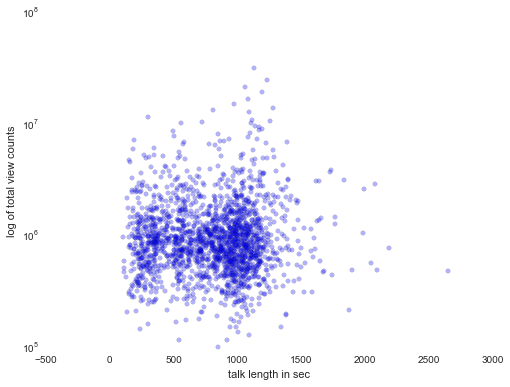

In [85]:
fig = plt.figure(figsize = (8,6))
ax1 = plt.gca()
ax1.scatter( x = captalks_f.length, y = captalks_f.viewed_count,
                marker = 'o', alpha = 0.3)
ax1.set_yscale('log')
plt.xlabel('talk length in sec')
plt.ylabel('log of total view counts')

In [86]:
def count_vs_cap(count,stat,ax):
    ax.set_yscale('log')
    ax.scatter(x = captalks_f[stat], y = captalks_f[count], marker = 'o', alpha = 0.2, label = count+' vs '+stat)
    ax.legend(loc = 'best',fontsize = 'large')

In [87]:
counts = list(captalks_f.columns[:3].values)

In [88]:
stats = ['length','num_para','word_per_sec']

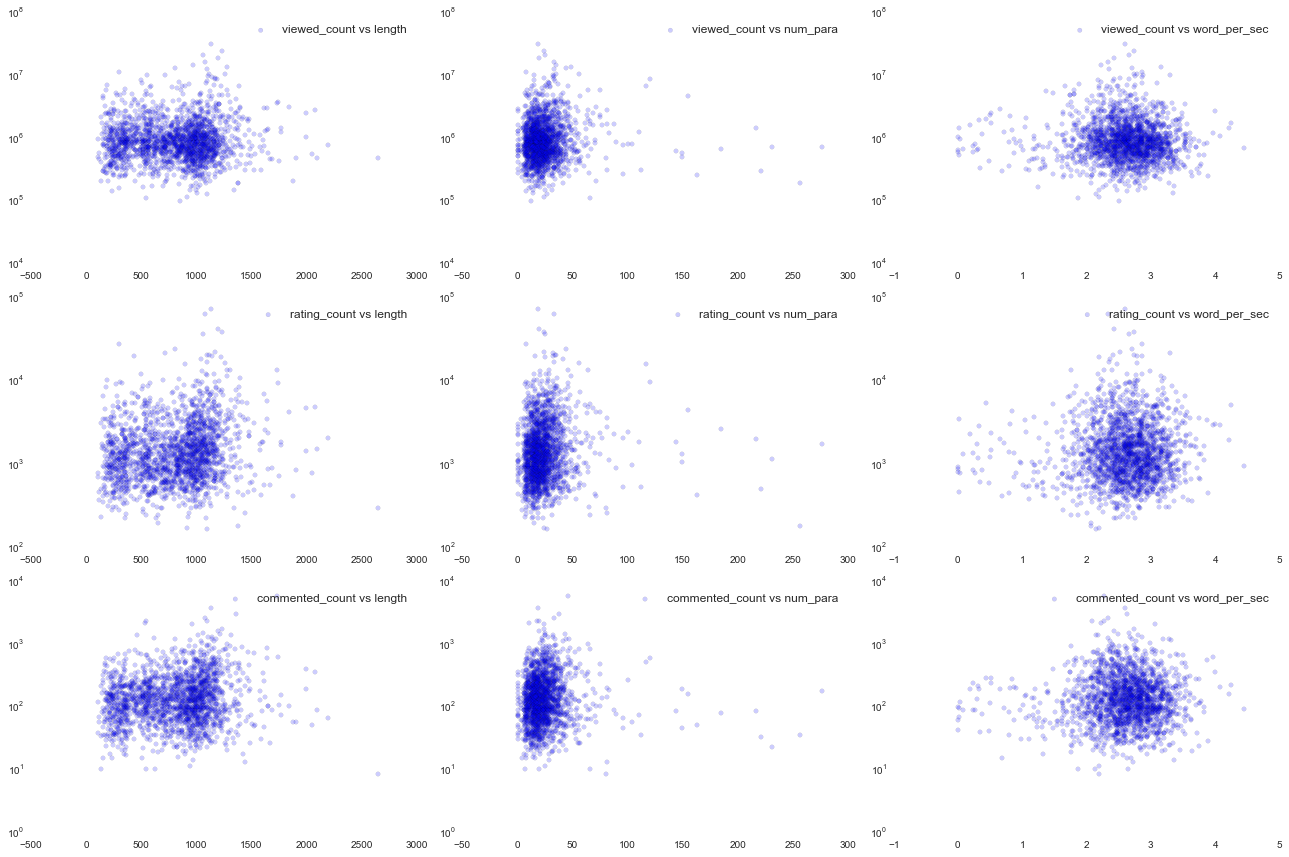

In [89]:
fig, axes=plt.subplots(figsize = (18,12),nrows=3, ncols=3)
for ind in xrange(9):
    i = ind/3;j = ind%3
    ax = axes[i][j]
    count_vs_cap(counts[i],stats[j],ax)
fig.tight_layout()

### raw dist plots of cap features so far

In [90]:
captalks_f.head()

,viewed_count,rating_count,commented_count,length,num_para,wordcounts,word_per_sec
id,,,,,,,
1,2842062,2485,244,944,16,2139,2.265890
2,956392,1511,78,879,27,2604,2.962457
3,650873,772,61,1099,22,2485,2.261146
4,1614164,1806,180,1152,28,3059,2.655382
5,711615,861,74,1177,28,3760,3.194562


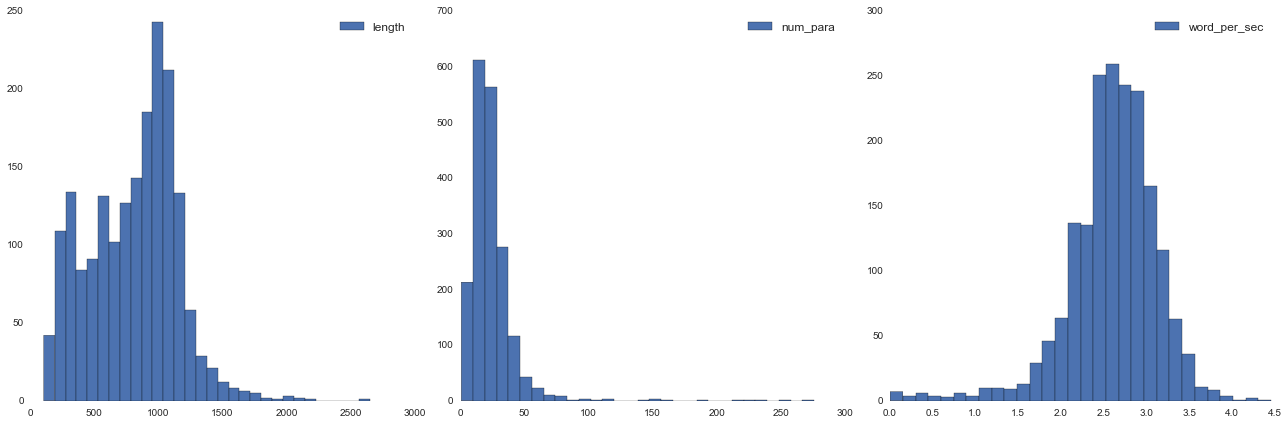

In [91]:
fig, axes=plt.subplots(figsize = (18,6),nrows=1, ncols=3)
for ind in xrange(3):
    ax = axes[ind]
    captalks_f[stats[ind]].hist(bins = 30, ax = ax, label = stats[ind])
    ax.legend(loc = 'best',fontsize = 'large')
fig.tight_layout()

In [92]:
ax = axes[0]

##2. Combine with Ted_4 to mining features from the transcripts

In [93]:
response = pd.read_csv('response5.csv',header = None)

In [94]:
response.columns = ['id','label']

### select captions from talks in the final training set 

In [95]:
ids = list(response['id'])

In [96]:
captions = capdata[capdata.index.get_level_values('id').isin(ids)]

In [97]:
len(captions.index.get_level_values('id').unique())

1535

In [98]:
captest = captions[captions.index.get_level_values('id')==114]['content']

In [99]:
sum(captest == '(Laughter)')

59

In [100]:
corpus = []
for idx in ids:
    text = []
    for index,row in captions[captions.index.get_level_values('id')==idx].iterrows():
        text.append(row['content'])
    corpus.append(text)

In [101]:
len(corpus)

1535

In [102]:
ids[0]

1

In [192]:
captions_f = pd.DataFrame(dict(id = ids, text = corpus))

In [193]:
captions_f.head(1)

,id,text
0,1,"[Thank you so much, Chris. And it's truly a gr..."


In [194]:
captions_f.shape

(1535, 2)

###2.1 Find how many "(Laughter)" and "(Applause)" 

####2.1.1Total number of laughter

In [195]:
import re

In [196]:
len(re.findall(r'(Laughter)',captions_f.text[0][4]))

1

In [198]:
def findalllaughter(text):
    content = ';'.join(text)
    num = len(re.findall(r'(Laughter)',content))
    return num

In [199]:
findalllaughter(captions_f.text[0])

10

In [200]:
laughter_total = captions_f.text.apply(findalllaughter)

In [201]:
captions_f['laughter_total'] = laughter_total

In [202]:
captions_f.head()

,id,text,laughter_total
0,1,"[Thank you so much, Chris. And it's truly a gr...",10
1,2,"[In terms of invention,, I'd like to tell you ...",6
2,2167,[When you grow up in a developing country\nlik...,0
3,3,"[A public, Dewey long ago observed,, is consti...",1
4,99,"[Okay., ♫ Strolling along in Central Park ♫, ♫...",2


In [203]:
temp = capstat[capstat['id'].isin(ids)]

In [204]:
temp.shape

(1535, 4)

In [205]:
captions_f = pd.merge(captions_f, capstat, on = 'id')

In [206]:
captions_f.head()

,id,text,laughter_total,length,num_para,wordcounts
0,1,"[Thank you so much, Chris. And it's truly a gr...",10,944.000,16,2139
1,2,"[In terms of invention,, I'd like to tell you ...",6,879.000,27,2604
2,2167,[When you grow up in a developing country\nlik...,0,967.755,25,1992
3,3,"[A public, Dewey long ago observed,, is consti...",1,1099.000,22,2485
4,99,"[Okay., ♫ Strolling along in Central Park ♫, ♫...",2,131.000,28,173


In [207]:
captions_f['laughter_per_word'] = captions_f['laughter_total']/captions_f.wordcounts

In [208]:
captions_f['word_per_sec'] = captions_f['wordcounts']/captions_f.length

In [209]:
captions_f['para_length'] = captions_f['wordcounts']/captions_f['num_para']

####2.1.2 How many applause 

In [210]:
def findallapplause(text):
    content = ';'.join(text)
    num = len(re.findall(r'(Applause)',content))
    return num

In [211]:
applause_total = captions_f.text.apply(findallapplause)

In [212]:
captions_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
       u'laughter_per_word',      u'word_per_sec',       u'para_length'],
      dtype='object')

In [213]:
captions_f['applause_total']= applause_total

In [214]:
captions_f.applause_total.describe()

count    1535.000000
mean        2.168730
std         1.992702
min         0.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        17.000000
Name: applause_total, dtype: float64

In [215]:
captions_f['applause_per_word']= captions_f['applause_total']/captions_f['wordcounts']

#### 2.1.3 How many "So" and "And so", "I think" "I don't think" , "--"

In [216]:
def countallso(text):
    content = ';'.join(text)
    num = len(re.findall(r'And so',content))
    return num

In [217]:
test = captions_f.text[934]

In [218]:
countallso(test)

13

In [219]:
countso = captions_f.text.apply(countallso)

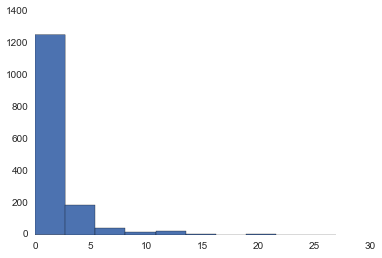

In [220]:
countso.hist()

In [221]:
captions_f['And_so_total'] = countso

In [222]:
captions_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
       u'laughter_per_word',      u'word_per_sec',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total'],
      dtype='object')

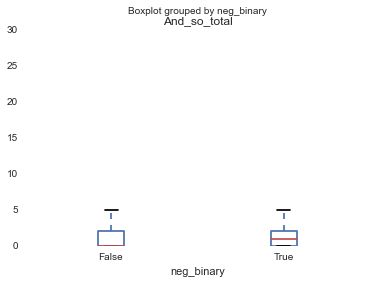

In [149]:
captions_f.boxplot(column = 'And_so_total', by = 'neg_binary')

In [150]:
# captions_f['so_per_para'] = captions_f['so_total']/captions_f['num_para']

#### So seems to be not predictive after a few trial, move on to "--", which often stands for interjections in the transcripts

In [224]:
# define a fun to find '--' and '-'
def finddiv(text):
    content = ';'.join(text)
    num = len(re.findall(r'--',content))
    return num

In [225]:
finddiv(test)

39

In [226]:
diversion = captions_f.text.apply(finddiv)

In [227]:
captions_f['diversion'] = diversion

### merge the response into captions_f 

In [229]:
captions_f = captions_f.merge(response, on = 'id')

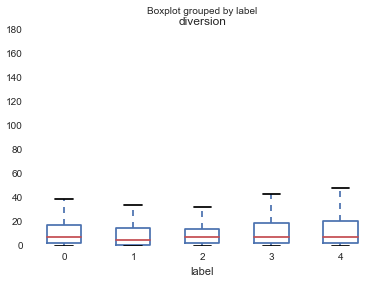

In [230]:
captions_f.boxplot(column = 'diversion', by = 'label')

In [231]:
div_per_word = captions_f.diversion/captions_f.wordcounts

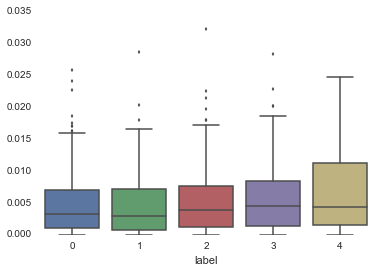

In [232]:
sns.boxplot(div_per_word,groupby = captions_f.label)

In [233]:
captions_f['div_per_word'] = div_per_word

In [234]:
div_per_word_labeled = [col for colname,col in captions_f.groupby('label')['div_per_word']]

In [236]:
f_val, p_val = ss.f_oneway(*div_per_word_labeled)
print 'p value is:{}'.format(p_val)

p value is:1.5824412727e-06


#### How about "I (don't) think" "my ** journey" 

In [237]:
def findthink(text):
    content = ';'.join(text)
    num = len(re.findall(r'I\s*[\w\']*\s*think',content))
    return num

In [238]:
test3 = captions_f.ix[643]['text']

In [239]:
findthink(test3)

34

In [240]:
ithinks = captions_f.text.apply(findthink)

In [241]:
ithinks.describe()

count    1535.000000
mean        2.667101
std         3.879449
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        39.000000
Name: text, dtype: float64

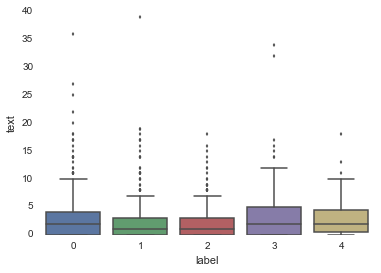

In [242]:
sns.boxplot(ithinks, groupby=captions_f.label)

In [243]:
captions_f['ithinks'] = ithinks

In [244]:
ithinks_labeled = [col for colname,col in captions_f.groupby('label')['ithinks']]

In [245]:
f_val, p_val = ss.f_oneway(*ithinks_labeled)
print 'p value is:{}'.format(p_val)

p value is:1.94337568156e-05


In [246]:
# (my) journey
def findstory(text):
    content = ';'.join(text)
    story_words = '|'.join(['journey','story','experience'])
    num = len(re.findall(story_words,content))
    return num

In [247]:
storywords = captions_f.text.apply(findstory)

In [248]:
storywords.describe()

count    1535.000000
mean        2.904235
std         3.740518
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        38.000000
Name: text, dtype: float64

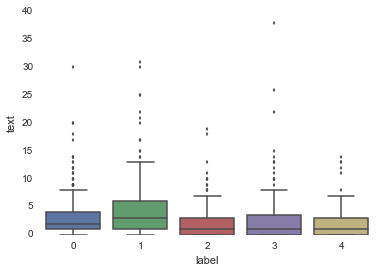

In [249]:
sns.boxplot(storywords, groupby=captions_f.label)

In [250]:
captions_f['storywords']=storywords

###2.2 Laughter or Applause as standalone paragraph 

In [251]:
def laughpara(text):
    counts = 0
    for paras in text:
        laugh = paras == '(Laughter)'
        counts += laugh
    return counts

In [252]:
laughpara = captions_f.text.apply(laughpara)

In [253]:
def applausepara(text):
    counts = 0
    for paras in text:
        laugh = paras == '(Applause)'
        counts += laugh
    return counts

In [254]:
applausepara = captions_f.text.apply(applausepara)

In [255]:
captions_f['app_as_para'] = applausepara
captions_f['laugh_as_para'] = laughpara

In [257]:
captions_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
       u'laughter_per_word',      u'word_per_sec',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para'],
      dtype='object')

In [258]:
talks_train = pd.read_json('train.json')

In [259]:
talks_train.reset_index(drop = True, inplace = True)

In [260]:
talks_train.shape

(1535, 31)

In [261]:
talks_train.sort(columns = 'id',inplace = True)

In [262]:
response.sort(columns = 'id',inplace = True)

In [263]:
talks_train = talks_train.merge(response, on = 'id')

In [264]:
captions_f.head()

,id,text,laughter_total,length,num_para,wordcounts,laughter_per_word,word_per_sec,para_length,applause_total,applause_per_word,And_so_total,diversion,label,div_per_word,ithinks,storywords,app_as_para,laugh_as_para
0,1,"[Thank you so much, Chris. And it's truly a gr...",10,944.000,16,2139,0.004675,2.265890,133.687500,4,0.001870,1,26,4,0.012155,1,6,2,2
1,2,"[In terms of invention,, I'd like to tell you ...",6,879.000,27,2604,0.002304,2.962457,96.444444,1,0.000384,4,14,1,0.005376,9,0,1,5
2,2167,[When you grow up in a developing country\nlik...,0,967.755,25,1992,0.000000,2.058372,79.680000,1,0.000502,0,2,0,0.001004,0,0,1,0
3,3,"[A public, Dewey long ago observed,, is consti...",1,1099.000,22,2485,0.000402,2.261146,112.954545,1,0.000402,0,32,0,0.012877,3,5,1,1
4,99,"[Okay., ♫ Strolling along in Central Park ♫, ♫...",2,131.000,28,173,0.011561,1.320611,6.178571,2,0.011561,1,0,4,0.000000,0,0,1,0


In [265]:
captions_f['funny_binary']= captions_f.label == 4
captions_f['neg_binary'] = captions_f.label == 3

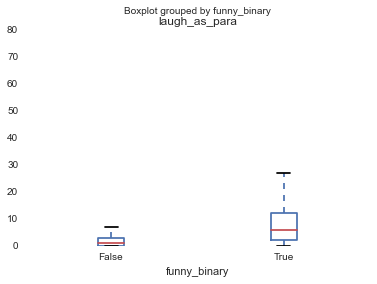

In [266]:
captions_f.boxplot(column='laugh_as_para',by = 'funny_binary',)

In [267]:
captions_f['app_total_log'] = captions_f['applause_total'].apply(lambda x: np.log10(x))

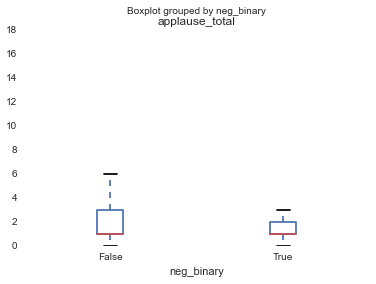

In [268]:
captions_f.boxplot(column='applause_total',by = 'neg_binary',)

In [269]:
captions_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
       u'laughter_per_word',      u'word_per_sec',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para',      u'funny_binary',        u'neg_binary',
           u'app_total_log'],
      dtype='object')

In [270]:
captions_f[captions_f.neg_binary==True].app_as_para.describe()

count    179.000000
mean       1.189944
std        0.952648
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        4.000000
Name: app_as_para, dtype: float64

In [271]:
captions_f[captions_f.neg_binary==False].app_as_para.describe()

count    1356.000000
mean        1.889381
std         1.814946
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        17.000000
Name: app_as_para, dtype: float64

###Save captions_f 

In [272]:
captions_f.columns

Index([               u'id',              u'text',    u'laughter_total',
                  u'length',          u'num_para',        u'wordcounts',
       u'laughter_per_word',      u'word_per_sec',       u'para_length',
          u'applause_total', u'applause_per_word',      u'And_so_total',
               u'diversion',             u'label',      u'div_per_word',
                 u'ithinks',        u'storywords',       u'app_as_para',
           u'laugh_as_para',      u'funny_binary',        u'neg_binary',
           u'app_total_log'],
      dtype='object')

In [273]:
captions_f.to_json('captions_f.json')

###2.3 Mining transcripts with spaCy and NLTK 

In [5]:
from __future__ import unicode_literals
from spacy.en import English, attrs
from spacy import en
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
from spacy.parts_of_speech import ADV, NOUN, ADJ, PUNCT, VERB

In [7]:
# remove punctuations
from string import punctuation

In [8]:
nlp = English()

In [9]:
captions_f = pd.read_json('captions_f.json')

In [10]:
captions_f.sort(columns = 'id',inplace = True)

In [11]:
captions_f.reset_index(inplace = True, drop = True)

In [12]:
captions_f.shape

(1535, 22)

### combine all paragraphs 

In [13]:
punset = set(punctuation)

In [14]:
stopset = set(stopwords.words('english'))

to keep it's that's etc unseparated, do this
test3 = re.sub('\'','\u2019',test2)

###2.3.1 Tokenize the text, lower the case, remove punctuations and interjections (laughter, mob, applause)

In [15]:
def tokenize(text):
    # return word tokens
    # text comes in as list of paragraph
    text = ' '.join(text)
    # remove '(Laughter)' etc, 
    text = re.sub('\([\w\s]+\)','',text)
    text = text.lower()
    tokens = nlp(text, parse = False)
    words = []
    for token in tokens:
        # remove punctuations
        if token.pos != PUNCT:
            words.append(token)
    return words

###2.3.2 Count stopwords 

In [17]:
def stopcounts(token_list):
    # token_list comes in as a list
    num_words = len(token_list)
    count = 0
    for token in token_list:
        if token.string.strip(' ').lower() in stopset:
            count += 1
    return count/float(num_words)

In [19]:
tokens = captions_f.text.apply(tokenize)

In [20]:
tokens.shape

(1535,)

In [21]:
captions_f['cap_tokens'] = tokens

In [22]:
stopwords_ratio = captions_f['cap_tokens'].apply(stopcounts)

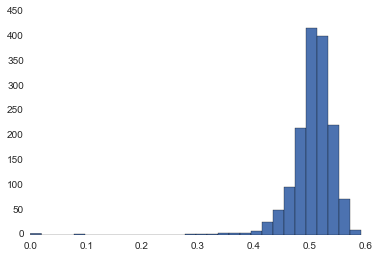

In [23]:
stopwords_ratio.hist(bins = 30)

In [24]:
captions_f['stopwords_ratio'] = stopwords_ratio

In [25]:
captions_f.columns

Index([     u'And_so_total',       u'app_as_para',     u'app_total_log',
       u'applause_per_word',    u'applause_total',      u'div_per_word',
               u'diversion',      u'funny_binary',                u'id',
                 u'ithinks',             u'label',     u'laugh_as_para',
       u'laughter_per_word',    u'laughter_total',            u'length',
              u'neg_binary',          u'num_para',       u'para_length',
              u'storywords',              u'text',      u'word_per_sec',
              u'wordcounts',        u'cap_tokens',   u'stopwords_ratio'],
      dtype='object')

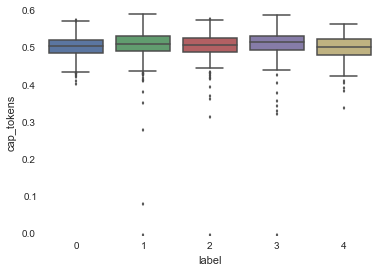

In [26]:
sns.boxplot(stopwords_ratio,groupby = captions_f.label)

In [27]:
stopwords_labeled = [col for colname,col in captions_f.groupby('label')['stopwords_ratio']]

In [30]:
f_val, p_val = ss.f_oneway(*stopwords_labeled)
print 'p value is:{}'.format(p_val)

p value is:0.361236442369


####So there is no evident difference  

### 2.3.2 Count important POS, take label class 2 (jaw-dropping) and 0 (informative) for example 

Take the most jaw-dropping but not informative talks(3) and the reversed 3 talks, look at the noun, adj and adv

In [175]:
jawids = [129, 65, 199]

In [176]:
infoids = [152, 899, 10]

The probability of tokens (verbs and nouns) are estimated based on counts from a 3 billion word corpus, smoothed using the simple good-turing methods. token.prob outputs the log prob

In [31]:
# define a function to take cap_tokens as input and output list of unique tokens 
# joined as a string for CountVectorizer 
def getpos(token_list,prob = -10,pos = ADJ):
    words = []
    for token in token_list:
        if token.pos == pos and token.prob < prob:
            words.append(token.lemma_)
            words = list(set(words))
    return words

In [32]:
captions_f['noun_token'] = captions_f.cap_tokens.apply(getpos,pos = NOUN, prob = -3).apply(lambda x: ' '.join(x))

In [33]:
captions_f['verb_token'] = captions_f.cap_tokens.apply(getpos,pos = VERB, prob = -3).apply(lambda x: ' '.join(x))

In [34]:
noungroupby = captions_f.groupby('label')['noun_token']

In [35]:
verbgroupby = captions_f.groupby('label')['verb_token']

In [36]:
# define a function to receive groupby obj and output dict(ind: most common vocab)
def sharedpos(groupbyobj,mindf, maxfeature):
    sharedtoken = dict()
    vect = CountVectorizer(min_df = mindf, binary = True, max_features = maxfeature)
    for ind, tokengb in groupbyobj:
        print ind, tokengb.as_matrix().shape
        vect.fit(tokengb.as_matrix())
        sharedtoken[ind]=set(vect.vocabulary_)
    return sharedtoken

In [37]:
sharednoun = sharedpos(noungroupby,0.6,100)

0 (474,)
1 (418,)
2 (353,)
3 (179,)
4 (111,)


In [38]:
sharedverb = sharedpos(verbgroupby,0.6, 100)

0 (474,)
1 (418,)
2 (353,)
3 (179,)
4 (111,)


In [39]:
common_noun = sharednoun[0]&sharednoun[1]&sharednoun[2]&sharednoun[3]&sharednoun[4]

In [40]:
vocab_noun = []
for value in sharednoun.itervalues():
    vocab_noun.extend(list(value))

In [41]:
vocab_noun_final = list(set(vocab_noun) - common_noun)

In [52]:
vocab_noun_final

[u'life',
 u'percent',
 u'question',
 u'story',
 u'idea',
 u'part',
 u'place',
 u'fact',
 u'example',
 u'problem',
 u'bit',
 u'kind',
 u'today']

In [42]:
common_verb = sharedverb[0]&sharedverb[1]&sharedverb[2]&sharedverb[3]&sharedverb[4]

In [43]:
vocab_verb = []
for value in sharedverb.itervalues():
    vocab_verb.extend(list(value))

In [44]:
vocab_verb_final = list(set(vocab_verb) - common_verb)

In [45]:
vocab_verb_final

[u'like',
 u'show',
 u'feel',
 u'should',
 u'leave',
 u'live',
 u'understand',
 u'talk',
 u'ask',
 u'become',
 u'change']

In [49]:
captions_f.drop('cap_tokens',axis = 1,inplace = True)

In [50]:
captions_f.columns

Index([     u'And_so_total',       u'app_as_para',     u'app_total_log',
       u'applause_per_word',    u'applause_total',      u'div_per_word',
               u'diversion',      u'funny_binary',                u'id',
                 u'ithinks',             u'label',     u'laugh_as_para',
       u'laughter_per_word',    u'laughter_total',            u'length',
              u'neg_binary',          u'num_para',       u'para_length',
              u'storywords',              u'text',      u'word_per_sec',
              u'wordcounts',   u'stopwords_ratio',        u'noun_token',
              u'verb_token'],
      dtype='object')

In [51]:
captions_f.to_json('captions_f.json')

In [53]:
from scipy.spatial.distance import cosine

In [162]:
nlp = English()

In [163]:
sculptor = nlp.vocab[u'sculptor']

In [164]:
sculptor.prob

-13.12763500213623

In [165]:
sculptor.repvec[:5]

array([-0.15213096, -0.00937699,  0.00855101, -0.05223943, -0.01507325], dtype=float32)

In [166]:
words = [w for w in nlp.vocab if w.has_repvec]

In [167]:
words.sort(key=lambda w: cosine(w.repvec, sculptor.repvec))

In [170]:
print '1-20', ', '.join(w.lower_ for w in words[0:20])

1-20 sculptor, sculptor, sculptor, painter, painter, painter, printmaker, architect, architect, architect, muralist, portraitist, miniaturist, caricaturist, illustrator, illustrator, engraver, dramatist, dramatist, ceramicist


Notice lemma is not defined for pronouns in WordNet, therefore the author makes up the policy;
Tag vs Pos: Pos (part-of-speech, from google universal tag set); Tag: a fine-grained morphosyntactic tag

###Test for instance, the distance between "sculptor" and "design, art, science, technology, global" 

In [70]:
testwords = ['design','science','artist','technology','global','painter','scientist']

In [71]:
for word in testwords:
    print word,cosine(nlp.vocab[word].repvec,sculptor.repvec)

design 0.628889799118
science 0.720556050539
artist 0.276574373245
technology 0.750671461225
global 0.859910815954
painter 0.129379868507
scientist 0.412072837353


In [69]:
nlp.vocab['good']

0.0

Gore's talk has 194 paragraphs

In [33]:
def countpos(text):
    posdict = dict()
    tokens = nlp(text,parse = False)
    for token in tokens:
        if token.pos_ in posdict.keys():
            posdict[token.pos_]+=1
        else:
            posdict[token.pos_]=1
    return posdict

In [34]:
posdict = countpos(test[0])

In [35]:
posdict

{u'ADJ': 1,
 u'ADV': 3,
 u'CONJ': 1,
 u'DET': 1,
 u'NOUN': 3,
 u'PRON': 2,
 u'PUNCT': 2,
 u'VERB': 1}

In [334]:
tokens = nlp(test[0])

In [338]:
tokens.count_by(attrs.POS)

{1L: 1, 2L: 3, 4L: 1, 5L: 1, 6L: 3, 8L: 2, 10L: 1, 12L: 2}

In [342]:
attrs.ORTH

65

In [350]:
for token in tokens:
    print token.orth_, token.prob

Thank -12.0132427216
you -6.68225240707
so -7.10154438019
much -7.50383710861
, -3.03683543205
Chris -10.0064516068
. -3.17597317696
And -7.47497653961
it -5.49812936783
's -4.73858451843
truly -10.7227811813
a -4.00384140015
great -8.39175319672
honor -10.3253259659


In [349]:
nlp.vocab[u'this'].prob

-6.227705478668213

In [351]:
truly = tokens[10]

In [352]:
truly.repvec.shape

(300,)